# Reshape 3D fields
to 2D nodes x depth

## Setup

In [16]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd 

import sys
sys.path.append("../")

import pyfesom as pf
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from matplotlib import cm 
from netCDF4 import Dataset

import glob

import cmocean as cmo
import cftime

from IPython import display
from tqdm import tqdm

sys.path.append("/albedo/home/quraus001/FESOM-FS-subduction/functions/")
import FESOM_processing as fp



In [2]:
meshpath = "/albedo/home/quraus001/Arc08_sub/"
datapath = "/albedo/work/user/cwekerle/Arc08_sub/"

In [3]:
# n3d.ini mesh

mesh   = pf.load_mesh(meshpath)
ds_ice = xr.open_dataset(datapath + "Arc40.2002.ice.mean.sub.nc")
ds_oce = xr.open_dataset(datapath + "Arc40.2002.oce.mean.sub.nc")

# Add depth & meta data
df_bath  = pd.read_csv(meshpath + "depth.out", skiprows=0, names=["bath"])
df_depth = pd.read_csv(meshpath + "nod3d.out", skiprows=1, names=["knot_num", "lon", "lat", "depth", "border_id"], sep='\s+', index_col=0)
df_aux3d = pd.read_csv(meshpath + "aux3d.out", skiprows=1, names=["knot_num"])

data = xr.DataArray(df_bath['bath'].values, dims=['nodes_2d'])
ds_oce['bath'] = data

data = xr.DataArray(df_depth['depth'].values, dims=['nodes_3d'])
ds_oce['depth'] = data

depth_levels = np.flip(np.array(sorted(list(set(ds_oce.depth.values))))) #np.unique
depth_levels = np.append(depth_levels, [np.nan, np.nan]) # fill the last two with nan (not present in Fram Strait data)

# Add depth_levels as a coordinate to ds_oce
ds_oce = ds_oce.assign_coords(depth_levels=depth_levels)

end = 570732*47
data = xr.DataArray(df_aux3d['knot_num'].values[:end].reshape(-1,47)-1, dims=['nodes_2d', "depth_levels"])
ds_oce['aux3d'] = data

del df_bath
del df_depth
del df_aux3d

print("Done")

/albedo/home/quraus001/Arc08_sub/pickle_mesh_py3
3
The usepickle == True)
The pickle file for python 3 exists.
The mesh will be loaded from /albedo/home/quraus001/Arc08_sub/pickle_mesh_py3
Done


In [4]:
ds_oce

<xarray.Dataset> Size: 100GB
Dimensions:       (time: 365, nodes_2d: 570732, nodes_3d: 13484072,
                   depth_levels: 47)
Coordinates:
  * time          (time) object 3kB 2002-01-01 23:57:30 ... 2002-12-31 23:57:30
  * depth_levels  (depth_levels) float64 376B 0.0 -10.0 -20.0 ... nan nan
Dimensions without coordinates: nodes_2d, nodes_3d
Data variables:
    iter          (time) int32 1kB ...
    ssh           (time, nodes_2d) float32 833MB ...
    u             (time, nodes_3d) float32 20GB ...
    v             (time, nodes_3d) float32 20GB ...
    w             (time, nodes_3d) float32 20GB ...
    temp          (time, nodes_3d) float32 20GB ...
    salt          (time, nodes_3d) float32 20GB ...
    bath          (nodes_2d) float64 5MB -82.0 -86.0 ... -3.906e+03 -3.908e+03
    depth         (nodes_3d) float64 108MB 0.0 0.0 0.0 ... -5.65e+03 -5.65e+03
    aux3d         (nodes_2d, depth_levels) int64 215MB 0 570732 ... -1000 -1000

In [5]:
def reshape_3d_nodes(ds: xr.Dataset, var: str, time_idx: int, fill_value: int = -999) -> np.ndarray:
    """
    Reshapes 3D node data from a FESOM dataset into a (2D node, depth) format.
    The dataset must have `aux3d` data with shape `(num_nodes_2d, num_depth_levels)` where each entry
    in `aux3d` corresponds to the 3D node number for each 2D node and depth level.

    Parameters:
    -----------
    ds : xarray.Dataset
        The dataset containing the 3D ocean model data.
    var : str
        The variable name (e.g., 'temp') to reshape.
    time_idx : int
        The time index for extracting data.
    fill_value : int, optional (default = -999)
        The value representing missing data in `aux3d_mapping`.

    Returns:
    --------
    np.ndarray
        A (num_nodes_2d, num_depth_levels) shaped array with the reshaped values.
    """

    # Read aux3d (Mapping wich 3D nodes are above each other)
    aux3d_mapping = ds['aux3d'].astype(int).values
    
    # Get data for one time step
    data_raw = ds[var].isel(time=time_idx)
    
    # Get dimension size & initialize reshaped array
    num_nodes_2d     = ds['nodes_2d'].size
    num_depth_levels = ds['depth_levels'].size
    data_reshaped = np.full((num_nodes_2d, num_depth_levels), np.nan)
    
    # Find the valid 3D indices for all nodes (where aux is actually refering to an existing node)
    valid_mask = (aux3d_mapping != fill_value) & (aux3d_mapping >= 0)
    valid_aux3d_indices = aux3d_mapping[valid_mask] # results in flat 1D boolean vector of valid entry positions
                                                    # this is not in the 0, 1, ...  num_3d_nodes order but goes trough each depth collumn
    
    # Get the corresponding (i, j) indices for the reshaped array
    row_indices_2d, col_indices_depth = np.where(valid_mask) # returns the row and column indices of valid entry positions
    
    # Perform the vectorized indexing
    # resort values
    original_values = data_raw.isel(nodes_3d=valid_aux3d_indices).values # resorts the values
    
    # Assign these values to the correct positions in the reshaped array
    data_reshaped[row_indices_2d, col_indices_depth] = np.where(np.isnan(original_values), np.nan, original_values)

    return data_reshaped

In [6]:
def simple_map(nodes_2d, mesh, levels, ticks, cmap, t):
    m = Basemap(projection='laea', resolution='i',
            width=1000000, height=700000,
            lat_0=79, lon_0=3)
    x2, y2 = m(mesh.x2, mesh.y2)
    
    
    
    fig, ax = plt.subplots(1,1, figsize=(7,4), constrained_layout=True)
    
    data,  elements = pf.get_data(ds_oce.temp.values[t,:],mesh, verbose=False)
    
    m.drawmapboundary(fill_color='0.9')
    m.drawcoastlines()
    
    im = ax.tricontourf(x2, y2, elements, nodes_2d, 
                 cmap=cmap,
                        extend="max",
                    levels=levels)#np.arange(-2,10,0.5))
    cbar = fig.colorbar(im, ax=ax, label="Depth [m]", ticks=ticks)
    cbar.ax.invert_yaxis()  # Flips the colorbar so deeper values are at the bottom
    
    
    formatted_date = ds_oce.time[t].values.item().strftime("%Y-%m-%d")
    ax.set_title(f"Depth of Tmax on {formatted_date}")
    #display.display(plt.gcf())
    #display.clear_output(wait=True)
    
    #fig.savefig(f"/albedo/home/quraus001/plots/T_max_depth/T_max_depth_{formatted_date}.png", dpi=200)
    fig.show()
    #plt.close()

In [13]:
mesh.y2

array([72.04083489, 72.0882586 , 72.04708988, ..., 84.50711257,
       84.54095436, 84.54761282], shape=(570732,))

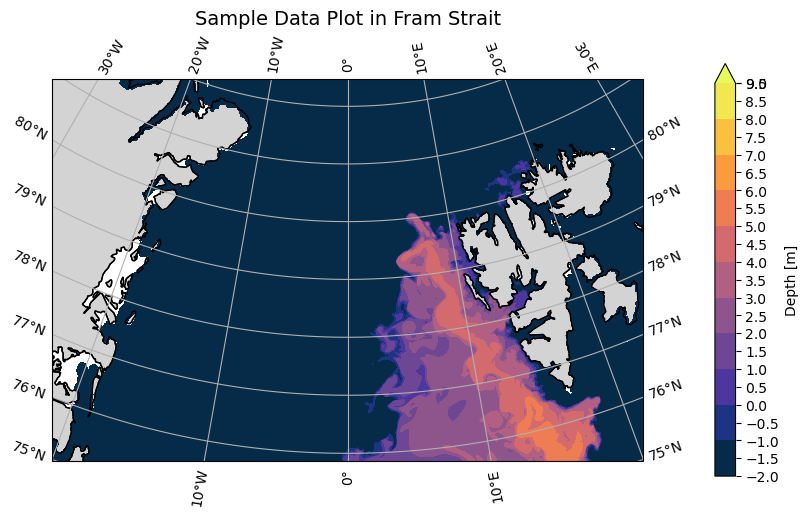

In [131]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

t=0
x2, y2 = (mesh.x2, mesh.y2)
data,  elements = pf.get_data(ds_oce.temp.values[t,:],mesh, verbose=False)

# Set up projection (North Polar Stereographic)
proj = ccrs.NorthPolarStereo()

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={'projection': proj}, constrained_layout=True)

# Set map extent (lon_min, lon_max, lat_min, lat_max)
ax.set_extent([-20, 20, 75, 82], crs=ccrs.PlateCarree())

# Add features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor='lightgray')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)


im = ax.tricontourf(x2, y2, elements, data, 
                 cmap=cmo.cm.thermal,
                        extend="max",
                    levels=np.arange(-2,10,1), transform=noProj)


cbar = fig.colorbar(im, ticks=ticks)
cbar.set_label("Depth [m]")


# Title
plt.title("Sample Data Plot in Fram Strait", fontsize=14)

plt.show()

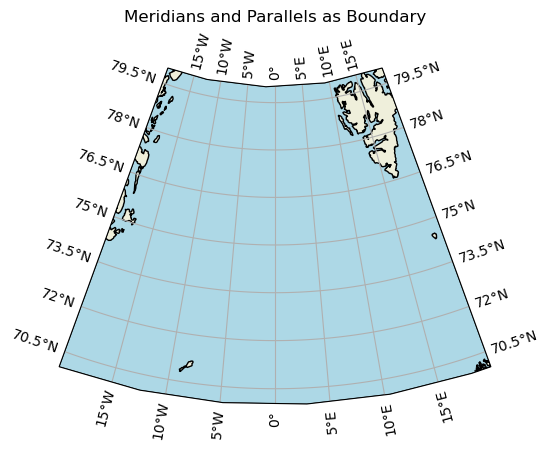

In [112]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import matplotlib.path as mpath

# The lat-long proj
noProj = ccrs.PlateCarree()
# The projection of the map
#myProj = ccrs.LambertConformal(central_longitude=-25, central_latitude=58.0)
myProj = ccrs.NorthPolarStereo()
myProj._threshold = myProj._threshold/20.  # Set for higher precision of the projection

ax = plt.axes(projection=myProj)

# This plots parallel and meridian arcs around a target area that will be used ...
#  as the map boundary
lat_min = 70
lat_max = 80
lon_min = -20
lon_max = 20
[ax_hdl] = ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min], [lat_min, lat_min, lat_max, lat_max, lat_min],
         color='black', linewidth=0.5, marker='none',
         transform=noProj)
# Get the `Path` of the plot
tx_path = ax_hdl._get_transformed_path()
path_in_data_coords, _ = tx_path.get_transformed_path_and_affine()

# Use the path's vertices to create a polygon
polygon = mpath.Path( path_in_data_coords.vertices )
ax.set_boundary(polygon) #This masks-out unwanted part of the plot

ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
ax.add_feature(cartopy.feature.OCEAN, linewidth=.3, color='lightblue')
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax.title.set_text("Meridians and Parallels as Boundary")
plt.show()

In [7]:
for t in tqdm(range(365)):
    temp_10 = reshape_3d_nodes(ds_oce, "temp", t)
    max_temp_10 = np.nanmax(temp_10, axis=1)
    max_temp_idx_10 = np.nanargmax(temp_10, axis=1)
    max_temp_depth_10 = np.take_along_axis(ds_oce.depth_levels.values, max_temp_idx_10, axis=0).squeeze()

    simple_map(nodes_2d=max_temp_depth_10*-1, mesh=mesh, levels=np.arange(0,400,20), ticks=np.arange(0,400,50), cmap=cmo.cm.deep,t=t)

100%|██████████| 365/365 [21:13<00:00,  3.49s/it]  


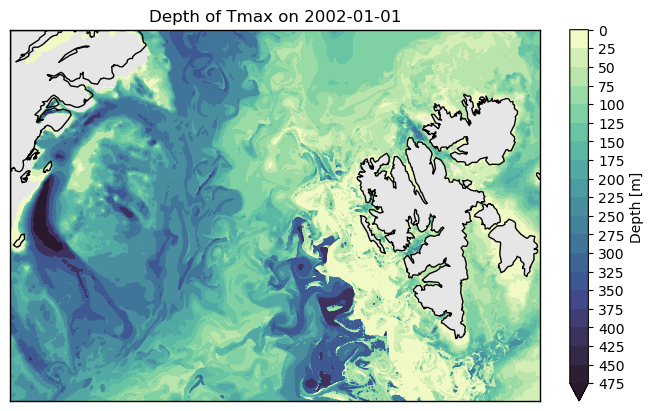

In [17]:
temp_10 = fp.reshape_3d_nodes(ds_oce, "temp", 0)
max_temp_10 = np.nanmax(temp_10, axis=1)
max_temp_idx_10 = np.nanargmax(temp_10, axis=1)
max_temp_depth_10 = np.take_along_axis(ds_oce.depth_levels.values, max_temp_idx_10, axis=0).squeeze()

simple_map(nodes_2d=max_temp_depth_10*-1, mesh=mesh, levels=np.arange(0,500,25), ticks=np.arange(0,500,25), cmap=cmo.cm.deep, t=0)

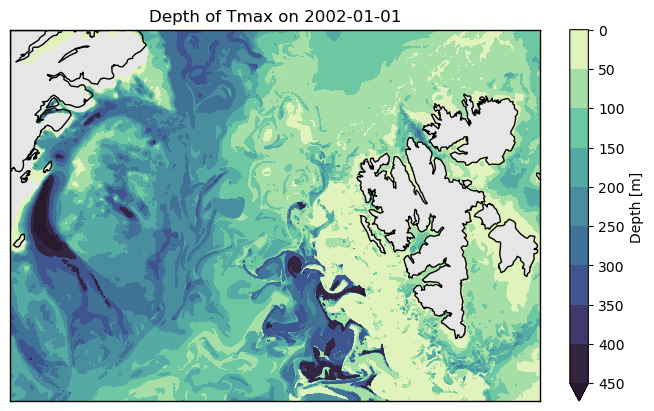

In [12]:
temp_10 = reshape_3d_nodes(ds_oce, "temp", 10)
max_temp_10 = np.nanmax(temp_10, axis=1)
max_temp_idx_10 = np.nanargmax(temp_10, axis=1)
max_temp_depth_10 = np.take_along_axis(ds_oce.depth_levels.values, max_temp_idx_10, axis=0).squeeze()

simple_map(nodes_2d=max_temp_depth_10*-1, mesh=mesh, levels=np.arange(0,500,50), ticks=np.arange(0,500,50), cmap=cmo.cm.deep)

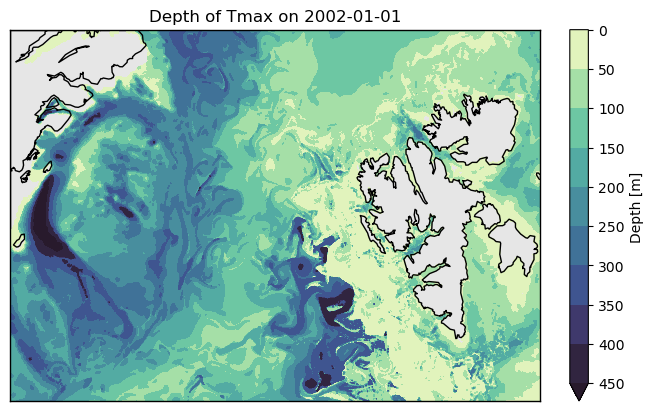

In [129]:
simple_map(nodes_2d=max_temp_depth*-1, mesh=mesh, levels=np.arange(0,500,50), ticks=np.arange(0,500,50), cmap=cmo.cm.deep)

In [62]:
for i in tqdm(range(10)):
    # --- Get the dimensions ---
    num_nodes_2d = ds_oce['nodes_2d'].size
    num_depth_levels = ds_oce['depth_levels'].size
    # --- Initialize the reshaped temperature array ---
    temp_reshaped_vectorized_2 = np.full((num_nodes_2d, num_depth_levels), np.nan)
    
    for i, depth in enumerate(ds_oce.depth_levels.values[:-2]):
        data, elements = pf.get_data(ds_oce.temp.values[0,:], mesh, verbose=False, depth=-depth)
        temp_reshaped_vectorized_2[:,i] = data
    
temp_reshaped_vectorized_2.shape, np.nanmean(temp_reshaped_vectorized_2), np.nanmax(temp_reshaped_vectorized_2)

100%|██████████| 10/10 [00:50<00:00,  5.05s/it]


((570732, 47), np.float64(0.5846456352105577), np.float64(8.013864517211914))

In [63]:
for i in tqdm(range(10)):
    # --- Get the aux3d mapping ---
    aux3d_mapping = ds_oce['aux3d'].astype(int).values
    
    # --- Get the original temperature data for the first time step ---
    if 'temp' not in ds_oce:
        print("Error: 'temp' variable not found in ds_oce.")
        exit()
    temp_original_t0 = ds_oce['temp'].isel(time=0)
    
    # Convert known missing values (-999, large placeholders) to NaN
    temp_original_t0 = temp_original_t0.where(
        (temp_original_t0 != -999) & (temp_original_t0 < 1e10), np.nan)
    
    # --- Get the dimensions ---
    num_nodes_2d = ds_oce['nodes_2d'].size
    num_depth_levels = ds_oce['depth_levels'].size
    
    # --- Initialize the reshaped temperature array ---
    temp_reshaped_vectorized = np.full((num_nodes_2d, num_depth_levels), np.nan)
    
    # --- Find the valid 3D indices for all nodes at once ---
    valid_mask = (aux3d_mapping != -999) & (aux3d_mapping >= 0)
    
    valid_aux3d_indices_flat = aux3d_mapping[valid_mask]
    
    # --- Get the corresponding (i, j) indices for the reshaped array ---
    row_indices_2d, col_indices_depth = np.where(valid_mask)
    
    # Debug: Check if valid indices are within the expected range
    if valid_aux3d_indices_flat.size > 0:
        #print("Max index in valid_aux3d_indices_flat:", np.max(valid_aux3d_indices_flat))
        #print("Size of nodes_3d in temp_original_t0:", temp_original_t0.sizes['nodes_3d'])
        if np.max(valid_aux3d_indices_flat) >= temp_original_t0.sizes['nodes_3d']:
            print("WARNING: Some indices in valid_aux3d_indices_flat are out of bounds!")
    
    # --- Perform the vectorized indexing ---
    try:
        # Get the temperature values for all valid 3D nodes at once
        original_temp_values = temp_original_t0.isel(nodes_3d=valid_aux3d_indices_flat).values
    
        # Assign these values to the correct positions in the reshaped array
        temp_reshaped_vectorized[row_indices_2d, col_indices_depth] = np.where(
            np.isnan(original_temp_values), np.nan, original_temp_values)
    
    except IndexError as e:
        print(f"IndexError during vectorized indexing: {e}")
        print("Shape of valid_aux3d_indices_flat:", valid_aux3d_indices_flat.shape)
        print("Max index in valid_aux3d_indices_flat:", np.max(valid_aux3d_indices_flat) if valid_aux3d_indices_flat.size > 0 else "empty")
        raise e
    
temp_reshaped_vectorized.shape, np.nanmean(temp_reshaped_vectorized), np.nanmax(temp_reshaped_vectorized)

100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


((570732, 47), np.float64(0.5846456352105577), np.float64(8.013864517211914))

In [68]:
max_temp = np.nanmax(temp_reshaped_vectorized, axis=1)
max_temp_idx = np.nanargmax(temp_reshaped_vectorized, axis=1)
max_temp_depth = np.take_along_axis(ds_oce.depth_levels.values, max_temp_idx, axis=0).squeeze()

(570732,)